In [1]:
__author__ = 'uak211'
import pandas as pd
import numpy as np
import os
import sys
import requests
import zipfile
import io
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

### read in data

In [2]:
# function i wrote for HW4 to download & unzip citibike csv
def get_citibike_data(datestring):
    '''
    downloads and unzips citibike csv data into the $PUIDATA directory.
    arguments:
        date string in format yyyymm
    ''' 
    file_root = '{}-citibike-tripdata'.format(datestring)
    if not ('2018' or '2017') in datestring:
        url = 'https://s3.amazonaws.com/tripdata/{}.zip'.format(file_root)
    else:
        url = 'https://s3.amazonaws.com/tripdata/{}.csv.zip'.format(file_root)

    r = requests.get(url)
    zip_ref = zipfile.ZipFile(io.BytesIO(r.content), 'r')
    zip_ref.extractall(os.getenv('PUIDATA'))
    zip_ref.close()

In [3]:
# including two months: one winter, one summer
winter_date = '201802'
summer_date = '201808'
get_citibike_data(winter_date)
get_citibike_data(summer_date)

In [4]:
# read in csvs
summer_file = '{}-citibike-tripdata'.format(summer_date)
winter_file = '{}-citibike-tripdata'.format(winter_date)
summer_bikes = pd.read_csv('{}/{}.csv'.format(os.getenv('PUIDATA'), summer_file))
winter_bikes = pd.read_csv('{}/{}.csv'.format(os.getenv('PUIDATA'), winter_file))

In [5]:
# joining datasets 
dfs = [winter_bikes, summer_bikes]
df = pd.concat(dfs)
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,771,2018-02-01 00:14:16.4120,2018-02-01 00:27:08.2290,72.0,W 52 St & 11 Ave,40.767272,-73.993929,379.0,W 31 St & 7 Ave,40.749156,-73.991600,14536,Subscriber,1952,1
1,264,2018-02-01 05:14:45.1790,2018-02-01 05:19:09.6860,72.0,W 52 St & 11 Ave,40.767272,-73.993929,478.0,11 Ave & W 41 St,40.760301,-73.998842,32820,Subscriber,1965,1
2,819,2018-02-01 06:48:55.2290,2018-02-01 07:02:35.0290,72.0,W 52 St & 11 Ave,40.767272,-73.993929,405.0,Washington St & Gansevoort St,40.739323,-74.008119,16131,Subscriber,1968,1
3,646,2018-02-01 07:12:50.1740,2018-02-01 07:23:36.5280,72.0,W 52 St & 11 Ave,40.767272,-73.993929,2006.0,Central Park S & 6 Ave,40.765909,-73.976342,20831,Subscriber,1990,2
4,1312,2018-02-01 07:46:48.8750,2018-02-01 08:08:41.5430,72.0,W 52 St & 11 Ave,40.767272,-73.993929,435.0,W 21 St & 6 Ave,40.741740,-73.994156,15899,Subscriber,1957,1


### data prep and sample creation

#### day and night duration

In [6]:
# pare down df to relevant columns
drop_cols = ['stoptime', 'end station id', 'end station name', 'end station latitude', 
             'end station longitude', 'bikeid', 'usertype']
df.drop(drop_cols, axis = 1, inplace = True)
list(df)

['tripduration',
 'starttime',
 'start station id',
 'start station name',
 'start station latitude',
 'start station longitude',
 'birth year',
 'gender']

In [7]:
# identify day and night riders
df['day_tripper'] = (pd.to_datetime(df['starttime']).dt.hour < 20) & (pd.to_datetime(df['starttime']).dt.hour >= 6) 

#### borough rider identification

In [8]:
# export df to csv to geocode lat/long coordinates in R (see HW README & geocode script in HW5 repo)
#df.to_csv('citibike.csv', index = False)

In [9]:
# import geocoded csv from $PUIDATA folder
df = pd.read_csv('{}/citibike.csv'.format(os.getenv('PUIDATA')))
# drop R's row names column
df.drop(df.columns[[0]], axis = 1, inplace = True)

In [10]:
# identify manhattan and brooklyn riders
df['mhtn_ride'] = df.boro_name.str.contains('Manhattan')
df['bklyn_ride'] = df.boro_name.str.contains('Brooklyn')

In [11]:
# remove birth year outliers and trip duration outliers and get age of rider
df = df[df['birth.year'] > df['birth.year'].quantile(0.001)]
df = df[df['tripduration'] < df['tripduration'].quantile(0.95)]
df['age'] = 2018 - df['birth.year']

In [12]:
# night/day trip duration and manhattan/brooklyn age variable creation
df['day_duration'] = df[df['day_tripper'] == 1].tripduration
df['night_duration'] = df[df['day_tripper'] == 0].tripduration
df['mhtn_age'] = df[df['mhtn_ride'] == 1].age
df['bklyn_age'] = df[df['bklyn_ride'] == 1].age

In [13]:
# get samples of both sets of populations
np.random.seed(123)
day_duration = np.sort(np.random.choice(df.day_duration[~np.isnan(df.day_duration)], size = len(df)/200, replace = False))
night_duration = np.sort(np.random.choice(df.night_duration[~np.isnan(df.night_duration)], size = len(df)/200, replace = False))
mhtn_age = np.sort(np.random.choice(df.mhtn_age[~np.isnan(df.mhtn_age)], size = len(df)/200, replace = False))
bklyn_age = np.sort(np.random.choice(df.bklyn_age[~np.isnan(df.bklyn_age)], size = len(df)/200, replace = False))

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### plotting

Text(0.5,1,'Fig. 12: age of brooklyn riders')

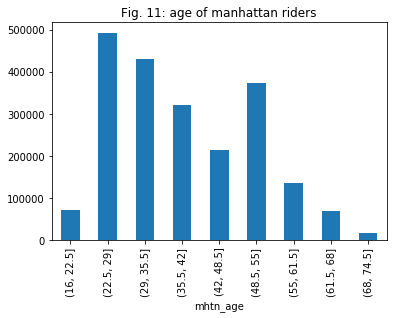

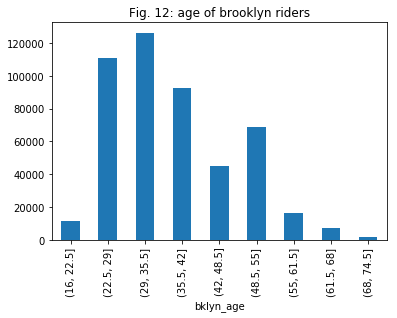

In [14]:
agemin, agemax = df.age.min(), df.age.max()
bins = np.arange(agemin, agemax, (agemax - agemin) / 10)
ax_m = df.mhtn_age.groupby(pd.cut(df.mhtn_age, bins)).agg([np.count_nonzero]).plot(kind = 'bar', legend = False)
ax_m.set_title("Fig. 11: age of manhattan riders") 

ax_b = df.bklyn_age.groupby(pd.cut(df.bklyn_age, bins)).agg([np.count_nonzero]).plot(kind='bar', legend = False)
ax_b.set_title("Fig. 12: age of brooklyn riders") 

Figs. 1, 2: histograms of citibike riders' ages for rides commenced in Manhattan and Brooklyn. The Manhattan ride volume is much higher, so the y-axes are scaled differently. The age distributions are both nearly bimodal with modes occuring in the same age ranges.

            count_nonzero
mhtn_age                 
(16, 22.5]       0.009849
(22.5, 29]       0.011137
(29, 35.5]       0.049185
(35.5, 42]       0.090171
(42, 48.5]       0.083347
(48.5, 55]       0.050497
(55, 61.5]       0.020155
(61.5, 68]       0.003271
(68, 74.5]       0.000000


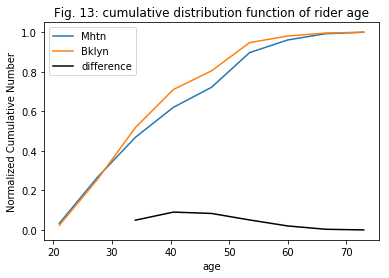

In [15]:
cs_m = df.mhtn_age.groupby(pd.cut(df.mhtn_age, bins)).agg([np.count_nonzero]).cumsum()

cs_b = df.bklyn_age.groupby(pd.cut(df.bklyn_age, bins)).agg([np.count_nonzero]).cumsum()

print (np.abs(cs_m / cs_m.max() - cs_b / cs_b.max()))

plt.plot(bins[:-1] + 5, cs_m / cs_m.max(), label = "Mhtn")
plt.plot(bins[:-1] + 5, cs_b / cs_b.max(), label = "Bklyn")
plt.plot(bins[:-1] + 5, np.sqrt(cs_b / cs_b.max() - cs_m / cs_m.max())**2, 'k-',
        label = "difference")
plt.title("Fig. 13: cumulative distribution function of rider age")
plt.xlabel("age")
plt.ylabel("Normalized Cumulative Number")
plt.legend()

Text(0.5,1,'Fig. 15: trip duration of night riders')

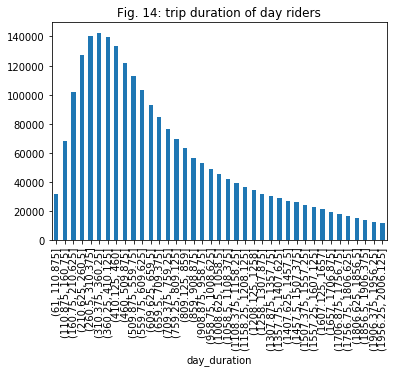

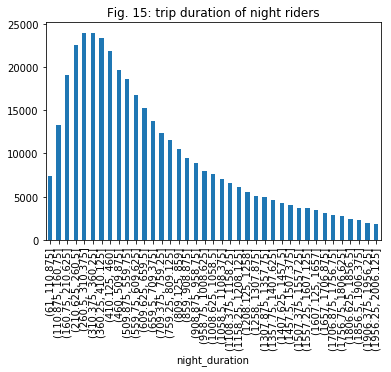

In [16]:
tpmin, tpmax = df.tripduration.min(), df.tripduration.max()
bins = np.arange(tpmin, tpmax, (tpmax - tpmin) / 40) 
ax_d = df.day_duration.groupby(pd.cut(df.day_duration, bins)).agg([np.count_nonzero]).plot(kind = 'bar', legend = False)
ax_d.set_title("Fig. 14: trip duration of day riders") 

ax_n = df.night_duration.groupby(pd.cut(df.night_duration, bins)).agg([np.count_nonzero]).plot(kind = 'bar', legend = False)
ax_n.set_title("Fig. 15: trip duration of night riders") 

Figs. 14, 15: histograms of day trip duration and night trip duration both show highly skewed distributions

                     count_nonzero
day_duration                      
(61, 110.875]             0.005387
(110.875, 160.75]         0.010440
(160.75, 210.625]         0.015553
(210.625, 260.5]          0.018600
(260.5, 310.375]          0.019554
(310.375, 360.25]         0.019342
(360.25, 410.125]         0.018821
(410.125, 460]            0.017182
(460, 509.875]            0.015146
(509.875, 559.75]         0.014103
(559.75, 609.625]         0.012407
(609.625, 659.5]          0.011252
(659.5, 709.375]          0.010170
(709.375, 759.25]         0.008973
(759.25, 809.125]         0.008683
(809.125, 859]            0.008129
(859, 908.875]            0.008184
(908.875, 958.75]         0.008110
(958.75, 1008.625]        0.007627
(1008.625, 1058.5]        0.007631
(1058.5, 1108.375]        0.007433
(1108.375, 1158.25]       0.007474
(1158.25, 1208.125]       0.007254
(1208.125, 1258]          0.006618
(1258, 1307.875]          0.006059
(1307.875, 1357.75]       0.005772
(1357.75, 1407.625] 

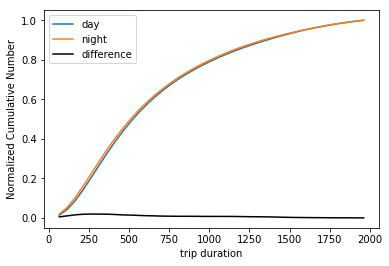

In [17]:
cs_d = df.day_duration.groupby(pd.cut(df.day_duration, bins)).agg([np.count_nonzero]).cumsum()

cs_n = df.night_duration.groupby(pd.cut(df.night_duration, bins)).agg([np.count_nonzero]).cumsum()

print (np.abs(cs_d / cs_d.max() - cs_n / cs_n.max()))

plt.plot(bins[:-1] + 5, cs_d / cs_d.max(), label = "day")
plt.plot(bins[:-1] + 5, cs_n / cs_n.max(), label = "night")
plt.plot(bins[:-1] + 5, np.sqrt(cs_n / cs_n.max() - cs_d / cs_d.max())**2, 'k-',
        label = "difference")
plt.xlabel("trip duration")
plt.ylabel("Normalized Cumulative Number")
plt.legend()

### sample tests

#### KS test to compare two samples

In [18]:
# full dataset and sample of day and night trips
ks_full = scipy.stats.ks_2samp(df.day_duration, df.night_duration)
ks_samp = scipy.stats.ks_2samp(day_duration, night_duration)
print ('full:', ks_full, ' sample:', ks_samp)

full: Ks_2sampResult(statistic=0.71134416022321667, pvalue=0.0)  sample: Ks_2sampResult(statistic=0.03035514018691593, pvalue=8.5665849361440488e-06)


In [19]:
# full dataset and sample of manhattan and brooklyn riders
ks_full = scipy.stats.ks_2samp(df.mhtn_age, df.bklyn_age)
ks_samp = scipy.stats.ks_2samp(mhtn_age, bklyn_age)
print ('full:', ks_full, ' sample:', ks_samp)

full: Ks_2sampResult(statistic=0.61440456840723301, pvalue=0.0)  sample: Ks_2sampResult(statistic=0.093383177570093401, pvalue=3.1361676510515741e-51)


the ks test tests whether two samples are drawn from the same distribution using the following hypotheses: 
* $H_0$: the distribution of trip duration of riders starting their trips between the hours of 
  6AM and 7:59PM equals the trip duration distribution for riders starting trips between the hours of 8PM and 5:59AM
* $H_0$: the distribution of ages of riders starting their trips in manhattan equals the distribution of ages of riders starting in brooklyn

we can reject the null hypothesis if the test's p-value is less than our set significance level of $\alpha$ = 0.05.
in both trip duration and age tests, the p-value is 0.0 for both the full dataset test and the sample test. we can therefore reject the null hypothesis in both cases and declare the distributions are not equal. 

#### pearson's test for correlation

In [20]:
# day/night trips
c, p = scipy.stats.pearsonr(day_duration, night_duration)
print('the correlation coefficient is {} and the p-value is {}.'.format(c, p))

# manhattan/brooklyn riders
r, a = scipy.stats.pearsonr(mhtn_age, bklyn_age)
print('the correlation coefficient is {} and the p-value is {}.'.format(r, a))

the correlation coefficient is 0.9998638393419543 and the p-value is 0.0.
the correlation coefficient is 0.9928573288440187 and the p-value is 0.0.


considering the null hypotheses:
* $H_0$: there is no relationsgip in the trip duration of riders starting their trips between the hours of 
  6AM and 7:59PM and riders starting trips between the hours of 8PM and 5:59AM
* $H_0$: there is no relationship in the age of riders starting their trips in manhattan and riders starting in brooklyn

with p-values less than $\alpha$ = 0.05 in pearson's tests for day/night and manhattan/brooklyn riders, we can reject both null hypotheses

#### spearman's test

In [21]:
# day/night trips
c, p = scipy.stats.spearmanr(day_duration, night_duration)
print('the correlation coefficient is {} and the p-value is {}.'.format(c, p))

# manhattan/brooklyn riders/
r, a = scipy.stats.spearmanr(mhtn_age, bklyn_age)
print('the correlation coefficient is {} and the p-value is {}.'.format(r, a))

the correlation coefficient is 0.9999991251004733 and the p-value is 0.0.
the correlation coefficient is 0.9983106957241107 and the p-value is 0.0.


considering the null hypotheses:
* $H_0$: there is no relationship in the median trip duration of riders starting their trips between the hours of 
  6AM and 7:59PM and riders starting trips between the hours of 8PM and 5:59AM
* $H_0$: there is no relationship in the median age of riders starting their trips in manhattan and riders starting in brooklyn

with p-values less than $\alpha$ = 0.05 in spearman's tests for both day/night and manhattan/brooklyn riders, we can reject both null hypotheses and declare there is a relationship in the medians in both cases. 